In [1]:
# processing
import pymysql.cursors
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scikitplot as skplt
from pandas import ExcelWriter
scaler = StandardScaler()
label = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline
# vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.externals.six import StringIO
import pydot
# model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
# classificators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.externals import joblib
import IDF
from sklearn.utils import resample
from datetime import datetime

In [2]:
# Подключиться к базе данных
def con():
    conn = pymysql.connect(
        host='10.100.0.100',
        port=33062,
        user='i.serov',
        password='7*&y9EkL',
        db='mysql')
    return conn

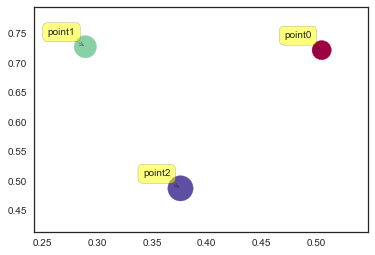

In [6]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
data = np.random.random((N, 4))
labels = ['point{0}'.format(i) for i in range(N)]

plt.subplots_adjust(bottom = 0.1)
plt.scatter(data[:, 0], data[:, 1], marker='o', c=data[:, 2], s=data[:, 3] * 1500,
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [3]:
%%time
df = pd.read_sql('''
SELECT
    if(cc2.total_payed <= 0.1 * c.initial_amount, 1, 0) AS is_bad,
    #1 = send to collection, 0 = do not send
    if(cc2.total_payed = 0, 1, 0)                       AS is_very_bad,
    datediff(w.next_income_date, c.date_requested)      AS days_bef_sal,
    cc1.*,
    p_d.*,
    w.*,
    i.*,
    b.is_filled_idv,
    b.is_reset_bank_account,
    b.has_online_banking
FROM moneyman_es.credit_calculations cc1
    LEFT JOIN moneyman_es.credit c
        ON cc1.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc2
        ON cc1.credit_id = cc2.credit_id AND cc1.calculation_date + INTERVAL 30 DAY = cc2.calculation_date
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.personal_data p_d
        ON b.personal_data_id = p_d.id
    LEFT JOIN moneyman_es.iovation i
        ON c.id = i.credit_id
WHERE cc1.status_days_count = 30  AND cc1.status = 'EXPIRED' AND credit_number = 1 AND 
cc1.total_payed <= 0.1 * c.initial_amount AND
      c.date_requested > '2016-01-01' and cc1.calculation_date < current_date() - interval 31 day AND cc1.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 30 AND expired_days_count = 30)
''', con=con())
df['age'] = 2018 - df['birthday'].apply(lambda x: x.year)
df1 = df.copy()
#df = df.sample(frac=1).reset_index(drop=True)

Wall time: 3.01 s


In [4]:
df.is_bad.value_counts()

1    8669
0    1051
Name: is_bad, dtype: int64

In [5]:
%%time
# Payments
payments = pd.read_sql('''
SELECT cp.*
FROM moneyman_es.credit_payment cp LEFT JOIN moneyman_es.credit_calculations cc
        ON cp.credit_id = cc.credit_id
    LEFT JOIN moneyman_es.credit c
        ON cc.credit_id = c.id
WHERE cc.status_days_count = 30 AND cc.status='EXPIRED' and 
cp.payment_date < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2016-01-01'
AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 30 AND expired_days_count = 30);
''', con=con())
payments1 = payments.copy()

Wall time: 4.93 s


In [6]:
%%time
# Payments
DD = pd.read_sql('''
SELECT sum(succ_DD) as succ_DD, sum(unsucc_DD) as unsucc_DD, credit_id
FROM (
SELECT
    if(recurrent IS TRUE AND result_code = 0, 1, 0) AS succ_DD,
    if(recurrent IS TRUE AND result_code <> 0, 1, 0) AS unsucc_DD,
    cp.*
FROM moneyman_es.payment cp LEFT JOIN moneyman_es.credit_calculations cc
        ON cp.credit_id = cc.credit_id
    LEFT JOIN moneyman_es.credit c
        ON cc.credit_id = c.id
WHERE cc.status_days_count = 30 AND cc.status = 'EXPIRED' AND
      cp.transaction_date < cc.calculation_date AND credit_number = 1 AND c.date_requested > '2016-01-01'
      AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 30 AND expired_days_count = 30)
ORDER BY id DESC) q
GROUP BY credit_id
''', con=con())

Wall time: 5.47 s


In [7]:
%%time
# Logins on site
logins = pd.read_sql('''
SELECT
    cc.credit_id,
    ul.*
FROM moneyman_es.user_login_history ul LEFT JOIN moneyman_es.borrower b
        ON ul.user_id = b.user_account_id
    LEFT JOIN moneyman_es.credit c
        ON b.id = c.borrower_id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.status_days_count = 30 AND cc.status='EXPIRED' and 
ul.login_date < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2016-01-01'
AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 30 AND expired_days_count = 30);
''', con=con())
logins1 = logins.copy()

Wall time: 6.68 s


In [8]:
%%time
# Collectors Calls
colcalls = pd.read_sql('''
SELECT
    coc.credit_id,
    cac.*
FROM moneyman_es.collector_action_call cac LEFT JOIN moneyman_es.collector_action_contact cacn
        ON cac.collector_action_contact_id = cacn.id
    LEFT JOIN moneyman_es.collector_action a
        ON cacn.collector_action_id = a.id
    LEFT JOIN moneyman_es.collector_credit coc
        ON a.collector_credit_id = coc.id
    LEFT JOIN moneyman_es.credit c
        ON coc.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.status_days_count = 30 AND cc.status='EXPIRED' and cac.call_date < cc.calculation_date 
AND c.credit_number = 1 AND c.date_requested>'2016-01-01'
AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 30 AND expired_days_count = 30);
''', con=con())
colcalls1 = colcalls.copy()

Wall time: 5.22 s


# Preprocessing

In [9]:
# logins
logs2 = logins.groupby('credit_id').agg({'id': 'count'}).reset_index().rename(columns={'id': 'count_logins'})
logs2['max_log_date'] = logins.groupby('credit_id').agg(
    {'login_date': 'max'}).reset_index().drop('credit_id', axis=1)
logins = logs2.copy()

In [10]:
# payments
payments = payments[['credit_id', 'amount', 'days_between_payments', 'payment_source',
                     'percent_to_pay', 'goal', 'goal_amount', 'collector_id', 'is_recurrent']]
p1 = payments.groupby('credit_id').agg({'is_recurrent': 'sum'}).reset_index().fillna(0)
p1['count_payments'] = payments.groupby('credit_id').agg({'goal': 'count'}).reset_index().fillna(0).rename(columns={'goal': 'count_payments'}).drop(
    'credit_id', axis=1)
p1['sum_p_amount'] = payments.groupby('credit_id').agg({'amount': 'sum'}).reset_index().fillna(0).rename(columns={'amount': 'sum_p_amount'}).drop(
    'credit_id', axis=1)
p1['max_p_amount'] = payments.groupby('credit_id').agg({'amount': 'max'}).reset_index().fillna(0).rename(columns={'amount': 'max_p_amount'}).drop(
    'credit_id', axis=1)
p1['min_p_amount'] = payments.groupby('credit_id').agg({'amount': 'min'}).reset_index().fillna(0).rename(columns={'amount': 'min_p_amount'}).drop(
    'credit_id', axis=1)
payments = p1

#### Collectors calls

In [11]:
# BIG SHAPE
colcalls['diff_status'] = colcalls['old_contact_status'] + '->' + colcalls['new_contact_status']
cc1 = colcalls.pivot_table(index=['credit_id'], columns='diff_status', aggfunc='size').reset_index().fillna(0)
c1 = colcalls.groupby('credit_id').agg({'duration': 'min'}).reset_index().fillna(0).rename(columns={'duration': 'min_duration'}).drop('credit_id', axis=1)
c1['max_duration'] = colcalls.groupby('credit_id').agg({'duration': 'max'}).reset_index().fillna(0).rename(columns={'duration': 'max_duration'}).drop('credit_id', axis=1)
c1['sum_duration'] = colcalls.groupby('credit_id').agg({'duration': 'sum'}).reset_index().fillna(0).rename(columns={'duration': 'sum_duration'}).drop('credit_id', axis=1)
colcs = pd.concat([cc1, c1], axis=1)

#### Df preprocessing

In [12]:
df.drop(['id', 'bonus_amount', 'status', 'prev_credit_calculation_id', 'first_name', 
         'full_name', 'first_last_name','maritalStatus_old','second_last_name', 'habitation_old', 'version',
         'payments_loans_currency', 'timezone_utc_offset','job_time', 'next_income_date', 'tel_number',
       'tel_number_extention','income_frequency_id','position', 'next_income_date2', 'tel_number_extension',
       'passport_identification_number', 'employer', 'amount_additional', 'currency_id_additional',
         'current_scope_time', 'employee_company_id', 'experience_in_current_place', 'general_experience',
       'spouse_mobile_number', 'spouse_full_name', 'phone_in_common_format', 'phone_in_common_format_crypt', 
         'id', 'date', 'response_date', 'trackingnumber', 'endblackbox', 'faultstring','device_flash_version',
       'device_alias', 'device_firstseen','device_browser_version', 'device_browser_charset',
       'device_browser_configured_lang', 'device_browser_lang','ipaddress', 'ipaddress_org', 'ipaddress_isp',
       'ipaddress_proxy', 'ipaddress_loc_city', 'ipaddress_loc_country_code',
       'ipaddress_loc_country', 'ipaddressLoc_region', 'realipaddress_source', 'realipaddress_org', 'realipaddress_isp',
       'realipaddress_proxy', 'realipaddress_loc_city', 'realipaddress_loc_country_code','ipaddress_loc_lat',
       'realipaddress_loc_country', 'realipaddress_loc_region','borrower_id', 'birthday', 'credit_id_2', 'result',
         'ipaddress_loc_lng', 'is_filled_idv', 'realipaddress', 'realipaddress_loc_lat', 'realipaddress_loc_lng',
         'is_reset_bank_account', 'has_online_banking','ruleset_rulesmatched', 'ruleset_score'
         ], axis=1, inplace=True)

In [13]:
df.columns = ['is_bad', 'is_very_bad', 'days_bef_sal', 'calculation_date','credit_id', 'expired_debt',
       'main_debt', 'main_debt_repaid', 'payments_amount', 'penalty_charge',
       'penalty_debt', 'penalty_repaid', 'percent_charge', 'percent_debt',
       'percent_repaid', 'status_days_count', 'status_reason_code',
       'total_debt', 'overpaid', 'total_payed', 'commission_amount',
       'forgiven_amount', 'expired_days_count', 'dependants_count',
       'maritalStatus', 'sex', 'habitation', 'payments_loans',
       'ID_document_type', 'credit_purpose_id', 'amount', 'currency_id',
       'education', 'employment_id', 'industry_id', 'post_id', 'full_job_time',
       'family_income', 'reason', 'device_new', 'device_screen', 'device_type',
       'device_os', 'device_tz', 'device_js_enabled', 'device_flash_enabled',
       'device_flash_installed', 'device_flash_storage_enabled',
       'device_flash_cookie_enabled', 'device_browser_type',
       'device_trust_score',    'registration_check_matchstatus', 'registration_check_measureofchange',
        'credit_id_2', 'age']

In [14]:
'''df.drop(['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason'
         ], axis=1, inplace=True)''';

In [15]:
df = pd.merge(colcs, pd.merge(logins, pd.merge(payments, pd.merge(DD, df, how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id')
X = df.copy()

In [16]:
cat_vars = ['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason'
         ]
for i in cat_vars:
    X[i]=label.fit_transform(X[i].astype(str))
X.fillna(-1, inplace=True)

# Model

In [134]:
#X = X1.copy()

In [129]:
def downsample(df):
    df_fail = df[df.is_bad==1]
    df_suc = df[df.is_bad==0]
    df_fail_ds = resample(df_fail,replace=False,n_samples=1000,random_state=123)
    df_downsampled = pd.concat([df_fail_ds, df_suc])
    df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
    return df_downsampled
#X1 = X.copy()
#X = downsample(X)

In [135]:
X_train = X[X.calculation_date<(datetime.strptime('2017-09-01', '%Y-%m-%d')).date()]
X_test = X[X.calculation_date>=(datetime.strptime('2017-09-01', '%Y-%m-%d')).date()]
#X_train = downsample(X_train)
y_train = X_train.is_bad
y_test = X_test.is_bad
X_train.drop(['is_bad', 'credit_id', 'calculation_date','is_very_bad', 'credit_id_2', 'max_log_date'], axis=1, inplace=True)
X_test.drop(['is_bad', 'credit_id', 'calculation_date','is_very_bad', 'credit_id_2', 'max_log_date'], axis=1, inplace=True)

In [136]:
#X.drop('max_log_date', axis=1,inplace=True)

In [137]:
#X.dtypes[(X.dtypes!=object) & (X.dtypes!=int) & (X.dtypes!=float)]
#X.dtypes[X.dtypes==object]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [138]:
'''clf = GradientBoostingClassifier(random_state=0)
tuned_parameters = [
                    {'n_estimators': np.arange(60, 100, 20)}
                    ]
gs = GridSearchCV(clf, tuned_parameters, cv=5, verbose=0).fit(X, y)''';

In [76]:
#cat_features = np.where(X_train.dtypes == object)[0]
#clf = SGDClassifier(loss = 'modified_huber', penalty='elasticnet', random_state = 1).fit(X_train, y_train)
#clf = RandomForestClassifier(random_state = 1).fit(X_train, y_train)
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 5,
                                 n_estimators = 100).fit(X_train, y_train)

In [139]:
clf = CatBoostClassifier(random_seed=42).fit(X_train, y_train)

0: learn: 0.6675381	total: 22.7ms	remaining: 22.7s
1: learn: 0.6417085	total: 71.4ms	remaining: 35.6s
2: learn: 0.6171053	total: 123ms	remaining: 41s
3: learn: 0.5945099	total: 166ms	remaining: 41.4s
4: learn: 0.5734442	total: 218ms	remaining: 43.4s
5: learn: 0.5545859	total: 246ms	remaining: 40.7s
6: learn: 0.5366444	total: 286ms	remaining: 40.6s
7: learn: 0.5200489	total: 315ms	remaining: 39.1s
8: learn: 0.5045499	total: 370ms	remaining: 40.7s
9: learn: 0.4916588	total: 386ms	remaining: 38.2s
10: learn: 0.4779747	total: 433ms	remaining: 38.9s
11: learn: 0.4653581	total: 474ms	remaining: 39s
12: learn: 0.4538008	total: 524ms	remaining: 39.8s
13: learn: 0.442913	total: 565ms	remaining: 39.8s
14: learn: 0.4330521	total: 605ms	remaining: 39.8s
15: learn: 0.424904	total: 622ms	remaining: 38.2s
16: learn: 0.4163507	total: 648ms	remaining: 37.5s
17: learn: 0.4075423	total: 698ms	remaining: 38.1s
18: learn: 0.3999421	total: 752ms	remaining: 38.8s
19: learn: 0.3939247	total: 769ms	remaining: 

165: learn: 0.2655529	total: 7.05s	remaining: 35.4s
166: learn: 0.2655009	total: 7.1s	remaining: 35.4s
167: learn: 0.2654502	total: 7.14s	remaining: 35.4s
168: learn: 0.2653819	total: 7.19s	remaining: 35.4s
169: learn: 0.2653096	total: 7.24s	remaining: 35.3s
170: learn: 0.2651952	total: 7.29s	remaining: 35.3s
171: learn: 0.2651469	total: 7.33s	remaining: 35.3s
172: learn: 0.2650605	total: 7.38s	remaining: 35.3s
173: learn: 0.2650257	total: 7.41s	remaining: 35.2s
174: learn: 0.264973	total: 7.45s	remaining: 35.1s
175: learn: 0.2649153	total: 7.5s	remaining: 35.1s
176: learn: 0.2648061	total: 7.55s	remaining: 35.1s
177: learn: 0.2646981	total: 7.59s	remaining: 35s
178: learn: 0.2645846	total: 7.64s	remaining: 35s
179: learn: 0.2644774	total: 7.68s	remaining: 35s
180: learn: 0.2643985	total: 7.74s	remaining: 35s
181: learn: 0.2642388	total: 7.78s	remaining: 35s
182: learn: 0.2640681	total: 7.83s	remaining: 35s
183: learn: 0.2638944	total: 7.88s	remaining: 34.9s
184: learn: 0.2637228	total

326: learn: 0.2423097	total: 15.3s	remaining: 31.5s
327: learn: 0.2422031	total: 15.4s	remaining: 31.5s
328: learn: 0.2419369	total: 15.4s	remaining: 31.5s
329: learn: 0.2417298	total: 15.5s	remaining: 31.4s
330: learn: 0.2415963	total: 15.6s	remaining: 31.5s
331: learn: 0.2413306	total: 15.6s	remaining: 31.4s
332: learn: 0.2410725	total: 15.7s	remaining: 31.4s
333: learn: 0.2409767	total: 15.7s	remaining: 31.4s
334: learn: 0.2408788	total: 15.8s	remaining: 31.4s
335: learn: 0.2407686	total: 15.9s	remaining: 31.4s
336: learn: 0.2406191	total: 16s	remaining: 31.4s
337: learn: 0.2404623	total: 16.1s	remaining: 31.4s
338: learn: 0.2402996	total: 16.1s	remaining: 31.4s
339: learn: 0.2402002	total: 16.2s	remaining: 31.4s
340: learn: 0.2401092	total: 16.2s	remaining: 31.3s
341: learn: 0.239882	total: 16.3s	remaining: 31.3s
342: learn: 0.2397578	total: 16.3s	remaining: 31.3s
343: learn: 0.239687	total: 16.4s	remaining: 31.2s
344: learn: 0.2395455	total: 16.4s	remaining: 31.2s
345: learn: 0.23

489: learn: 0.2164315	total: 23.4s	remaining: 24.4s
490: learn: 0.2163591	total: 23.5s	remaining: 24.3s
491: learn: 0.2162225	total: 23.5s	remaining: 24.3s
492: learn: 0.2161865	total: 23.6s	remaining: 24.2s
493: learn: 0.2159937	total: 23.6s	remaining: 24.2s
494: learn: 0.2158182	total: 23.7s	remaining: 24.1s
495: learn: 0.215686	total: 23.7s	remaining: 24.1s
496: learn: 0.2156142	total: 23.8s	remaining: 24s
497: learn: 0.215493	total: 23.8s	remaining: 24s
498: learn: 0.2153099	total: 23.9s	remaining: 23.9s
499: learn: 0.2151845	total: 23.9s	remaining: 23.9s
500: learn: 0.2150399	total: 23.9s	remaining: 23.9s
501: learn: 0.214953	total: 24s	remaining: 23.8s
502: learn: 0.2148375	total: 24s	remaining: 23.8s
503: learn: 0.2145887	total: 24.1s	remaining: 23.7s
504: learn: 0.2144298	total: 24.1s	remaining: 23.7s
505: learn: 0.2142629	total: 24.2s	remaining: 23.6s
506: learn: 0.2141392	total: 24.2s	remaining: 23.6s
507: learn: 0.2140083	total: 24.3s	remaining: 23.5s
508: learn: 0.2138862	t

652: learn: 0.1957165	total: 31.9s	remaining: 16.9s
653: learn: 0.1955522	total: 31.9s	remaining: 16.9s
654: learn: 0.1954583	total: 32s	remaining: 16.8s
655: learn: 0.1953213	total: 32s	remaining: 16.8s
656: learn: 0.1952168	total: 32s	remaining: 16.7s
657: learn: 0.195153	total: 32.1s	remaining: 16.7s
658: learn: 0.1950119	total: 32.1s	remaining: 16.6s
659: learn: 0.1949836	total: 32.2s	remaining: 16.6s
660: learn: 0.1949131	total: 32.2s	remaining: 16.5s
661: learn: 0.1948817	total: 32.3s	remaining: 16.5s
662: learn: 0.1948418	total: 32.3s	remaining: 16.4s
663: learn: 0.1947903	total: 32.4s	remaining: 16.4s
664: learn: 0.1947415	total: 32.4s	remaining: 16.3s
665: learn: 0.1946925	total: 32.5s	remaining: 16.3s
666: learn: 0.1945597	total: 32.5s	remaining: 16.2s
667: learn: 0.1944973	total: 32.6s	remaining: 16.2s
668: learn: 0.1943361	total: 32.6s	remaining: 16.1s
669: learn: 0.1941058	total: 32.7s	remaining: 16.1s
670: learn: 0.1940176	total: 32.7s	remaining: 16s
671: learn: 0.1938561

814: learn: 0.1791011	total: 40.5s	remaining: 9.2s
815: learn: 0.1790276	total: 40.6s	remaining: 9.15s
816: learn: 0.1789196	total: 40.6s	remaining: 9.1s
817: learn: 0.1788159	total: 40.7s	remaining: 9.05s
818: learn: 0.1787258	total: 40.7s	remaining: 9s
819: learn: 0.1786564	total: 40.8s	remaining: 8.96s
820: learn: 0.1786022	total: 40.9s	remaining: 8.91s
821: learn: 0.1785317	total: 40.9s	remaining: 8.86s
822: learn: 0.1784944	total: 41s	remaining: 8.81s
823: learn: 0.1783816	total: 41s	remaining: 8.76s
824: learn: 0.1783165	total: 41.1s	remaining: 8.71s
825: learn: 0.1781451	total: 41.1s	remaining: 8.66s
826: learn: 0.1780325	total: 41.2s	remaining: 8.62s
827: learn: 0.1778489	total: 41.2s	remaining: 8.57s
828: learn: 0.177713	total: 41.3s	remaining: 8.52s
829: learn: 0.1776696	total: 41.3s	remaining: 8.47s
830: learn: 0.1775304	total: 41.4s	remaining: 8.42s
831: learn: 0.177426	total: 41.5s	remaining: 8.37s
832: learn: 0.1773811	total: 41.5s	remaining: 8.32s
833: learn: 0.1771882	t

978: learn: 0.1652189	total: 48.8s	remaining: 1.05s
979: learn: 0.1651625	total: 48.9s	remaining: 997ms
980: learn: 0.1650233	total: 48.9s	remaining: 947ms
981: learn: 0.1649342	total: 49s	remaining: 897ms
982: learn: 0.1648945	total: 49s	remaining: 847ms
983: learn: 0.1648859	total: 49.1s	remaining: 798ms
984: learn: 0.1648279	total: 49.1s	remaining: 748ms
985: learn: 0.1647379	total: 49.1s	remaining: 698ms
986: learn: 0.1646808	total: 49.2s	remaining: 648ms
987: learn: 0.164614	total: 49.2s	remaining: 598ms
988: learn: 0.1645826	total: 49.3s	remaining: 548ms
989: learn: 0.1644582	total: 49.3s	remaining: 498ms
990: learn: 0.1644102	total: 49.4s	remaining: 449ms
991: learn: 0.1643238	total: 49.4s	remaining: 399ms
992: learn: 0.1641858	total: 49.5s	remaining: 349ms
993: learn: 0.1641335	total: 49.5s	remaining: 299ms
994: learn: 0.1640557	total: 49.6s	remaining: 249ms
995: learn: 0.1638727	total: 49.6s	remaining: 199ms
996: learn: 0.1638272	total: 49.7s	remaining: 149ms
997: learn: 0.163

Confusion Matrix:
[[  68  141]
 [ 432 3630]]


ROC_AUC:  0.6095036503572615
Gini:  0.219007300714523
F1_score:  0.9268479509766373


Classification_report: 
              precision    recall  f1-score   support

        0.0       0.14      0.33      0.19       209
        1.0       0.96      0.89      0.93      4062

avg / total       0.92      0.87      0.89      4271





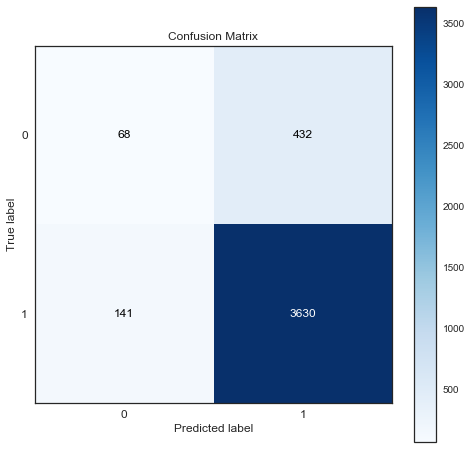

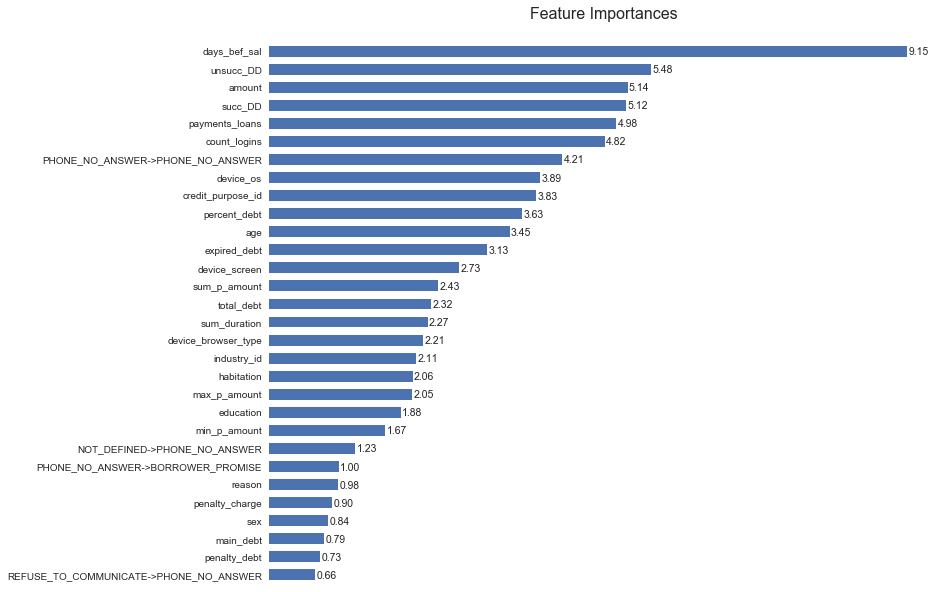

In [143]:
IDF.plot_score(clf, X_test, y_test)

In [142]:
print (classification_report(pd.Series(clf.predict_proba(X_test)[:,1]).apply(lambda x: 1 if x>0.5 else 0), y_test))

             precision    recall  f1-score   support

          0       0.14      0.33      0.19       209
          1       0.96      0.89      0.93      4062

avg / total       0.92      0.87      0.89      4271



In [89]:
joblib.dump(clf3, 'ES_col_30.pkl');

In [ ]:
df_test['prediction_proba'] = clf.predict_proba(X_test)[:,1]
writer = pd.ExcelWriter('V1_BR_DD.xlsx')
df_test[['amount','success', 'prediction_proba']].to_excel(writer,'BR_DD_TEST_DATA', index=False)
writer.save()

# Only for credits between dates

In [40]:
min_date = '2017-03-19'
max_date = '2017-03-19' 

In [41]:
%%time
df = pd.read_sql('''
SELECT
    1 AS is_bad,
    1                   AS is_very_bad,
    datediff(w.next_income_date, c.date_requested) as days_bef_sal,
    cc1.*,
    p_d.*,
    w.*,
    i.*,
    b.is_filled_idv,
    b.is_reset_bank_account,
    b.has_online_banking
FROM moneyman_es.credit_calculations cc1
    LEFT JOIN moneyman_es.credit c
        ON cc1.credit_id = c.id
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.personal_data p_d
        ON b.personal_data_id = p_d.id
    LEFT JOIN moneyman_es.iovation i
        ON i.credit_id = c.id
WHERE cc1.calculation_date>='%s' and cc1.status='EXPIRED' and cc1.calculation_date<='%s' and cc1.status_days_count = 30 AND credit_number = 1 AND c.date_requested>'2017-01-01'
order by cc1.credit_id
''' % (str(min_date), str(max_date)), con=con())
df['age'] = 2018 - df['birthday'].apply(lambda x: x.year)
df1 = df.copy()
#df = df.sample(frac=1).reset_index(drop=True)

Wall time: 391 ms


In [42]:
%%time
# SMS-Notifitcations
sms = pd.read_sql('''
SELECT
    cc.credit_id,
    n.*
FROM moneyman_es.notification_sms n LEFT JOIN moneyman_es.borrower b
        ON n.borrower_id = b.id
    LEFT JOIN moneyman_es.credit c
        ON b.id = c.borrower_id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND n.date_sent < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
sms1 = sms.copy()

Wall time: 869 ms


In [43]:
%%time
# Payments
payments = pd.read_sql('''
SELECT cp.*
FROM moneyman_es.credit_payment cp LEFT JOIN moneyman_es.credit_calculations cc
        ON cp.credit_id = cc.credit_id
    LEFT JOIN moneyman_es.credit c
        ON cc.credit_id = c.id
WHERE cc.calculation_date>='%s' and cc.status='EXPIRED' and cc.calculation_date<='%s' and cc.expired_days_count = 30 AND cp.payment_date < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
payments1 = payments.copy()

Wall time: 312 ms


In [44]:
%%time
# Logins on site
logins = pd.read_sql('''
SELECT
    cc.credit_id,
    ul.*
FROM moneyman_es.user_login_history ul LEFT JOIN moneyman_es.borrower b
        ON ul.user_id = b.user_account_id
    LEFT JOIN moneyman_es.credit c
        ON b.id = c.borrower_id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND ul.login_date < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
logins1 = logins.copy()

Wall time: 302 ms


In [45]:
%%time
# Collectors Calls
colcalls = pd.read_sql('''
SELECT
    coc.credit_id,
    cac.*
FROM moneyman_es.collector_action_call cac LEFT JOIN moneyman_es.collector_action_contact cacn
        ON cac.collector_action_contact_id = cacn.id
    LEFT JOIN moneyman_es.collector_action a
        ON cacn.collector_action_id = a.id
    LEFT JOIN moneyman_es.collector_credit coc
        ON a.collector_credit_id = coc.id
    LEFT JOIN moneyman_es.credit c
        ON coc.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE  cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND cac.call_date < cc.calculation_date AND c.credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
colcalls1 = colcalls.copy()

Wall time: 387 ms


In [46]:
sms_columns = [
    'credit_id', 'ADMIN_MESSAGE', 'AWAITING_PHONE_CONFIRMATION',
    'CONFIRMATION_CODE', 'CREDIT_BEFORE_EXPIRED',
    'CREDIT_BEFORE_EXPIRED_PROMISE', 'CREDIT_COMPLETED', 'CREDIT_EXPIRED',
    'CREDIT_EXPIRED_11_30_1', 'CREDIT_EXPIRED_11_30_2',
    'CREDIT_EXPIRED_11_30_3', 'CREDIT_EXPIRED_11_30_4',
    'CREDIT_EXPIRED_1_10_1', 'CREDIT_EXPIRED_1_10_2', 'CREDIT_EXPIRED_1_10_3',
    'CREDIT_EXPIRED_1_10_4', 'CREDIT_EXPIRED_31_45_1',
    'CREDIT_EXPIRED_31_45_2', 'CREDIT_EXPIRED_31_45_4',
    'CREDIT_EXPIRED_46_60_1', 'CREDIT_EXPIRED_46_60_2',
    'CREDIT_EXPIRED_PROMISE', 'CREDIT_PENDING_RISK_BORROWER',
    'DEBIT_CARD_NOTIFICATION', 'OFFER', 'PAYMENT_COMPLETED',
    'PAYMENT_RECEIVED', 'PRE_APPROVAL_LOANS_NOTIFICATIONS_1',
    'RECOVERY_PASSWORD', 'REGISTRATION_SUCCESS', 'RESTRUCTING_FIRST_PAYMENT',
    'RESTRUCTING_OFFER', 'RESTRUCTING_TODAY_PAYMENT',
    'RESTRUCTING_TOMORROW_PAYMENT', 'ROLLOVER_CREDIT_TODAY_ENDS',
    'ROLLOVER_CREDIT_TOMORROW_ENDS', 'SCORING_LIMIT_CREDIT_AMOUNT',
    'SENT_MONEY', 'count_all_sms', 'DELIVERED', 'ERROR', 'NOT_DELIVERED',
    'PREPARED_FOR_SENDING', 'QUEUED', 'REJECTD'
]

colcs_columns = [
    'credit_id', 'BORROWER_DID_NOT_TAKE_CREDIT->BORROWER_DID_NOT_TAKE_CREDIT',
    'BORROWER_DID_NOT_TAKE_CREDIT->BORROWER_REFUSES_TO_PAY',
    'BORROWER_DID_NOT_TAKE_CREDIT->NO_FUNDS_ON_ACCOUNT',
    'BORROWER_DID_NOT_TAKE_CREDIT->PHONE_NO_ANSWER',
    'BORROWER_DID_NOT_TAKE_CREDIT->REFUSE_TO_COMMUNICATE',
    'BORROWER_DID_NOT_TAKE_CREDIT->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_FINANCIAL_PROBLEMS->BORROWER_FINANCIAL_PROBLEMS',
    'BORROWER_FINANCIAL_PROBLEMS->BORROWER_PROMISE',
    'BORROWER_FINANCIAL_PROBLEMS->BORROWER_REFUSES_TO_PAY',
    'BORROWER_FINANCIAL_PROBLEMS->CALL_BACK',
    'BORROWER_FINANCIAL_PROBLEMS->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_FINANCIAL_PROBLEMS->MONEY_SENT',
    'BORROWER_FINANCIAL_PROBLEMS->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_FINANCIAL_PROBLEMS->PHONE_NOT_USED',
    'BORROWER_FINANCIAL_PROBLEMS->PHONE_NO_ANSWER',
    'BORROWER_FINANCIAL_PROBLEMS->REFUSE_TO_COMMUNICATE',
    'BORROWER_FINANCIAL_PROBLEMS->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_INACTIVE->BORROWER_PROMISE', 'BORROWER_INACTIVE->CALL_BACK',
    'BORROWER_INACTIVE->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_INACTIVE->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_INACTIVE->PHONE_NO_ANSWER',
    'BORROWER_INACTIVE->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_NEVER_WORKS->BORROWER_NEVER_WORKS',
    'BORROWER_NEVER_WORKS->BORROWER_NO_LONGER_WORKS',
    'BORROWER_NEVER_WORKS->CALL_BACK', 'BORROWER_NEVER_WORKS->PHONE_NO_ANSWER',
    'BORROWER_NEVER_WORKS->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_NO_LONGER_WORKS->BORROWER_NO_LONGER_WORKS',
    'BORROWER_NO_LONGER_WORKS->BORROWER_REFUSES_TO_PAY',
    'BORROWER_NO_LONGER_WORKS->PHONE_NO_ANSWER',
    'BORROWER_NO_LONGER_WORKS->THIRD_PERSON_NEGATIVE',
    'BORROWER_NO_LONGER_WORKS->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_NO_LONGER_WORKS->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_PROMISE->BORROWER_DID_NOT_TAKE_CREDIT',
    'BORROWER_PROMISE->BORROWER_FINANCIAL_PROBLEMS',
    'BORROWER_PROMISE->BORROWER_INACTIVE',
    'BORROWER_PROMISE->BORROWER_PROMISE',
    'BORROWER_PROMISE->BORROWER_REFUSES_TO_PAY', 'BORROWER_PROMISE->CALL_BACK',
    'BORROWER_PROMISE->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_PROMISE->DEBT_NOTIFICATION_SENT', 'BORROWER_PROMISE->MONEY_SENT',
    'BORROWER_PROMISE->NO_FUNDS_ON_ACCOUNT',
    'BORROWER_PROMISE->PAYMENT_CONFIRMATION',
    'BORROWER_PROMISE->PHONE_BELONG_ANOTHER_PERSON',
    'BORROWER_PROMISE->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_PROMISE->PHONE_NOT_USED', 'BORROWER_PROMISE->PHONE_NO_ANSWER',
    'BORROWER_PROMISE->REFUSE_TO_COMMUNICATE',
    'BORROWER_PROMISE->REPLY_CONSULTATION',
    'BORROWER_PROMISE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'BORROWER_PROMISE->THIRD_PERSON_NEGATIVE',
    'BORROWER_PROMISE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_PROMISE->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_REFUSES_TO_PAY->BORROWER_DID_NOT_TAKE_CREDIT',
    'BORROWER_REFUSES_TO_PAY->BORROWER_FINANCIAL_PROBLEMS',
    'BORROWER_REFUSES_TO_PAY->BORROWER_NEVER_WORKS',
    'BORROWER_REFUSES_TO_PAY->BORROWER_PROMISE',
    'BORROWER_REFUSES_TO_PAY->BORROWER_REFUSES_TO_PAY',
    'BORROWER_REFUSES_TO_PAY->CALL_BACK',
    'BORROWER_REFUSES_TO_PAY->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_REFUSES_TO_PAY->DEBT_NOTIFICATION_SENT',
    'BORROWER_REFUSES_TO_PAY->MONEY_SENT',
    'BORROWER_REFUSES_TO_PAY->PHONE_BELONG_ANOTHER_PERSON',
    'BORROWER_REFUSES_TO_PAY->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_REFUSES_TO_PAY->PHONE_NOT_USED',
    'BORROWER_REFUSES_TO_PAY->PHONE_NO_ANSWER',
    'BORROWER_REFUSES_TO_PAY->REFUSE_TO_COMMUNICATE',
    'BORROWER_REFUSES_TO_PAY->REPLY_CONSULTATION',
    'BORROWER_REFUSES_TO_PAY->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_REFUSES_TO_PAY->THIRD_PERSON_SEND_MESSAGE',
    'CALL_BACK->BORROWER_DID_NOT_TAKE_CREDIT',
    'CALL_BACK->BORROWER_FINANCIAL_PROBLEMS', 'CALL_BACK->BORROWER_INACTIVE',
    'CALL_BACK->BORROWER_NEVER_WORKS', 'CALL_BACK->BORROWER_PROMISE',
    'CALL_BACK->BORROWER_REFUSES_TO_PAY', 'CALL_BACK->CALL_BACK',
    'CALL_BACK->CLIENT_MADE_PAYMENT_LOAN', 'CALL_BACK->MONEY_SENT',
    'CALL_BACK->PHONE_BELONG_ANOTHER_PERSON',
    'CALL_BACK->PHONE_IS_NOT_AVAILABLE', 'CALL_BACK->PHONE_NOT_USED',
    'CALL_BACK->PHONE_NO_ANSWER', 'CALL_BACK->REFUSE_TO_COMMUNICATE',
    'CALL_BACK->THIRD_PERSON_NEGATIVE',
    'CALL_BACK->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'CALL_BACK->THIRD_PERSON_SEND_MESSAGE',
    'CLAIM_OF_INCORRECT_EMAIL->CLAIM_OF_INCORRECT_EMAIL',
    'CLAIM_OF_INCORRECT_EMAIL->DEBT_NOTIFICATION_SENT',
    'CLIENT_MADE_PAYMENT_LOAN->BORROWER_FINANCIAL_PROBLEMS',
    'CLIENT_MADE_PAYMENT_LOAN->BORROWER_PROMISE',
    'CLIENT_MADE_PAYMENT_LOAN->BORROWER_REFUSES_TO_PAY',
    'CLIENT_MADE_PAYMENT_LOAN->CALL_BACK',
    'CLIENT_MADE_PAYMENT_LOAN->CLIENT_MADE_PAYMENT_LOAN',
    'CLIENT_MADE_PAYMENT_LOAN->MONEY_SENT',
    'CLIENT_MADE_PAYMENT_LOAN->PHONE_IS_NOT_AVAILABLE',
    'CLIENT_MADE_PAYMENT_LOAN->PHONE_NO_ANSWER',
    'CLIENT_MADE_PAYMENT_LOAN->REFUSE_TO_COMMUNICATE',
    'CLIENT_MADE_PAYMENT_LOAN->THIRD_PERSON_SEND_MESSAGE',
    'DEBT_NOTIFICATION_SENT->BORROWER_PROMISE',
    'DEBT_NOTIFICATION_SENT->BORROWER_REFUSES_TO_PAY',
    'DEBT_NOTIFICATION_SENT->CLAIM_OF_INCORRECT_EMAIL',
    'DEBT_NOTIFICATION_SENT->DEBT_NOTIFICATION_SENT',
    'DEBT_NOTIFICATION_SENT->PAYMENT_CONFIRMATION',
    'DEBT_NOTIFICATION_SENT->REPLY_CONSULTATION',
    'MONEY_SENT->BORROWER_FINANCIAL_PROBLEMS', 'MONEY_SENT->BORROWER_PROMISE',
    'MONEY_SENT->BORROWER_REFUSES_TO_PAY', 'MONEY_SENT->CALL_BACK',
    'MONEY_SENT->CLIENT_MADE_PAYMENT_LOAN', 'MONEY_SENT->MONEY_SENT',
    'MONEY_SENT->NO_FUNDS_ON_ACCOUNT', 'MONEY_SENT->PHONE_NO_ANSWER',
    'MONEY_SENT->REFUSE_TO_COMMUNICATE',
    'MONEY_SENT->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'NOT_DEFINED->BORROWER_DID_NOT_TAKE_CREDIT',
    'NOT_DEFINED->BORROWER_FINANCIAL_PROBLEMS',
    'NOT_DEFINED->BORROWER_INACTIVE', 'NOT_DEFINED->BORROWER_NEVER_WORKS',
    'NOT_DEFINED->BORROWER_NO_LONGER_WORKS', 'NOT_DEFINED->BORROWER_PROMISE',
    'NOT_DEFINED->BORROWER_REFUSES_TO_PAY', 'NOT_DEFINED->CALL_BACK',
    'NOT_DEFINED->CLAIM_OF_INCORRECT_EMAIL',
    'NOT_DEFINED->CLIENT_MADE_PAYMENT_LOAN',
    'NOT_DEFINED->DEBT_NOTIFICATION_SENT', 'NOT_DEFINED->MONEY_SENT',
    'NOT_DEFINED->NO_FUNDS_ON_ACCOUNT', 'NOT_DEFINED->PAYMENT_CONFIRMATION',
    'NOT_DEFINED->PHONE_BELONG_ANOTHER_PERSON',
    'NOT_DEFINED->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'NOT_DEFINED->PHONE_IS_NOT_AVAILABLE', 'NOT_DEFINED->PHONE_NOT_USED',
    'NOT_DEFINED->PHONE_NO_ANSWER', 'NOT_DEFINED->REFUSE_TO_COMMUNICATE',
    'NOT_DEFINED->REPLY_CONSULTATION', 'NOT_DEFINED->RESTRUCTURIZATION_AGREED',
    'NOT_DEFINED->THIRD_PERSON_DONT_KNOW_CLIENT',
    'NOT_DEFINED->THIRD_PERSON_NEGATIVE',
    'NOT_DEFINED->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'NOT_DEFINED->THIRD_PERSON_SEND_MESSAGE',
    'NO_FUNDS_ON_ACCOUNT->BORROWER_REFUSES_TO_PAY',
    'NO_FUNDS_ON_ACCOUNT->CLIENT_MADE_PAYMENT_LOAN',
    'NO_FUNDS_ON_ACCOUNT->NO_FUNDS_ON_ACCOUNT',
    'NO_FUNDS_ON_ACCOUNT->PHONE_NO_ANSWER',
    'NO_FUNDS_ON_ACCOUNT->REFUSE_TO_COMMUNICATE',
    'NO_FUNDS_ON_ACCOUNT->THIRD_PERSON_SEND_MESSAGE',
    'PAYMENT_CONFIRMATION->BORROWER_PROMISE',
    'PAYMENT_CONFIRMATION->BORROWER_REFUSES_TO_PAY',
    'PAYMENT_CONFIRMATION->DEBT_NOTIFICATION_SENT',
    'PAYMENT_CONFIRMATION->PAYMENT_CONFIRMATION',
    'PAYMENT_CONFIRMATION->REPLY_CONSULTATION',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_DID_NOT_TAKE_CREDIT',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_NEVER_WORKS',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_NO_LONGER_WORKS',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_REFUSES_TO_PAY',
    'PHONE_BELONG_ANOTHER_PERSON->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_BELONG_ANOTHER_PERSON->PHONE_NO_ANSWER',
    'PHONE_BELONG_ANOTHER_PERSON->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_BELONG_ANOTHER_PERSON->THIRD_PERSON_SEND_MESSAGE',
    'PHONE_BELONG_ORG_DONT_KNOW_CLIENT->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'PHONE_BELONG_ORG_DONT_KNOW_CLIENT->PHONE_NO_ANSWER',
    'PHONE_BELONG_ORG_DONT_KNOW_CLIENT->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_FINANCIAL_PROBLEMS',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_INACTIVE',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_NEVER_WORKS',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_PROMISE',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_REFUSES_TO_PAY',
    'PHONE_IS_NOT_AVAILABLE->CALL_BACK',
    'PHONE_IS_NOT_AVAILABLE->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_IS_NOT_AVAILABLE->PHONE_IS_NOT_AVAILABLE',
    'PHONE_IS_NOT_AVAILABLE->PHONE_NOT_USED',
    'PHONE_IS_NOT_AVAILABLE->PHONE_NO_ANSWER',
    'PHONE_IS_NOT_AVAILABLE->REFUSE_TO_COMMUNICATE',
    'PHONE_IS_NOT_AVAILABLE->THIRD_PERSON_NEGATIVE',
    'PHONE_IS_NOT_AVAILABLE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_IS_NOT_AVAILABLE->THIRD_PERSON_SEND_MESSAGE',
    'PHONE_NOT_USED->BORROWER_FINANCIAL_PROBLEMS',
    'PHONE_NOT_USED->BORROWER_NO_LONGER_WORKS',
    'PHONE_NOT_USED->BORROWER_PROMISE',
    'PHONE_NOT_USED->BORROWER_REFUSES_TO_PAY', 'PHONE_NOT_USED->CALL_BACK',
    'PHONE_NOT_USED->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_NOT_USED->PHONE_IS_NOT_AVAILABLE', 'PHONE_NOT_USED->PHONE_NOT_USED',
    'PHONE_NOT_USED->PHONE_NO_ANSWER', 'PHONE_NOT_USED->REFUSE_TO_COMMUNICATE',
    'PHONE_NOT_USED->THIRD_PERSON_SEND_MESSAGE',
    'PHONE_NO_ANSWER->BORROWER_DID_NOT_TAKE_CREDIT',
    'PHONE_NO_ANSWER->BORROWER_FINANCIAL_PROBLEMS',
    'PHONE_NO_ANSWER->BORROWER_INACTIVE',
    'PHONE_NO_ANSWER->BORROWER_NEVER_WORKS',
    'PHONE_NO_ANSWER->BORROWER_NO_LONGER_WORKS',
    'PHONE_NO_ANSWER->BORROWER_PROMISE',
    'PHONE_NO_ANSWER->BORROWER_REFUSES_TO_PAY', 'PHONE_NO_ANSWER->CALL_BACK',
    'PHONE_NO_ANSWER->CLIENT_MADE_PAYMENT_LOAN', 'PHONE_NO_ANSWER->MONEY_SENT',
    'PHONE_NO_ANSWER->NO_FUNDS_ON_ACCOUNT',
    'PHONE_NO_ANSWER->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_NO_ANSWER->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'PHONE_NO_ANSWER->PHONE_IS_NOT_AVAILABLE',
    'PHONE_NO_ANSWER->PHONE_NOT_USED', 'PHONE_NO_ANSWER->PHONE_NO_ANSWER',
    'PHONE_NO_ANSWER->REFUSE_TO_COMMUNICATE',
    'PHONE_NO_ANSWER->THIRD_PERSON_DONT_KNOW_CLIENT',
    'PHONE_NO_ANSWER->THIRD_PERSON_NEGATIVE',
    'PHONE_NO_ANSWER->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_NO_ANSWER->THIRD_PERSON_SEND_MESSAGE',
    'REFUSE_TO_COMMUNICATE->BORROWER_FINANCIAL_PROBLEMS',
    'REFUSE_TO_COMMUNICATE->BORROWER_NEVER_WORKS',
    'REFUSE_TO_COMMUNICATE->BORROWER_PROMISE',
    'REFUSE_TO_COMMUNICATE->BORROWER_REFUSES_TO_PAY',
    'REFUSE_TO_COMMUNICATE->CALL_BACK', 'REFUSE_TO_COMMUNICATE->MONEY_SENT',
    'REFUSE_TO_COMMUNICATE->PHONE_BELONG_ANOTHER_PERSON',
    'REFUSE_TO_COMMUNICATE->PHONE_IS_NOT_AVAILABLE',
    'REFUSE_TO_COMMUNICATE->PHONE_NOT_USED',
    'REFUSE_TO_COMMUNICATE->PHONE_NO_ANSWER',
    'REFUSE_TO_COMMUNICATE->REFUSE_TO_COMMUNICATE',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_NEGATIVE',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_SEND_MESSAGE',
    'REPLY_CONSULTATION->BORROWER_PROMISE',
    'REPLY_CONSULTATION->BORROWER_REFUSES_TO_PAY',
    'REPLY_CONSULTATION->DEBT_NOTIFICATION_SENT',
    'REPLY_CONSULTATION->PAYMENT_CONFIRMATION',
    'REPLY_CONSULTATION->REPLY_CONSULTATION',
    'RESTRUCTURIZATION_AGREED->DEBT_NOTIFICATION_SENT',
    'THIRD_PERSON_DONT_KNOW_CLIENT->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_DONT_KNOW_CLIENT->PHONE_BELONG_ANOTHER_PERSON',
    'THIRD_PERSON_DONT_KNOW_CLIENT->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'THIRD_PERSON_DONT_KNOW_CLIENT->PHONE_NO_ANSWER',
    'THIRD_PERSON_DONT_KNOW_CLIENT->REFUSE_TO_COMMUNICATE',
    'THIRD_PERSON_DONT_KNOW_CLIENT->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_DONT_KNOW_CLIENT->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_DONT_KNOW_CLIENT->THIRD_PERSON_SEND_MESSAGE',
    'THIRD_PERSON_NEGATIVE->BORROWER_NEVER_WORKS',
    'THIRD_PERSON_NEGATIVE->BORROWER_NO_LONGER_WORKS',
    'THIRD_PERSON_NEGATIVE->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_NEGATIVE->PHONE_NO_ANSWER',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_SEND_MESSAGE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_DID_NOT_TAKE_CREDIT',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_NEVER_WORKS',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_NO_LONGER_WORKS',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_PROMISE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->PHONE_BELONG_ANOTHER_PERSON',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->PHONE_IS_NOT_AVAILABLE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->PHONE_NO_ANSWER',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->REFUSE_TO_COMMUNICATE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_SEND_MESSAGE',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_DID_NOT_TAKE_CREDIT',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_FINANCIAL_PROBLEMS',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_NEVER_WORKS',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_NO_LONGER_WORKS',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_PROMISE',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_SEND_MESSAGE->CALL_BACK',
    'THIRD_PERSON_SEND_MESSAGE->CLIENT_MADE_PAYMENT_LOAN',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_BELONG_ANOTHER_PERSON',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_IS_NOT_AVAILABLE',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_NO_ANSWER',
    'THIRD_PERSON_SEND_MESSAGE->REFUSE_TO_COMMUNICATE',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_SEND_MESSAGE', 'min_duration',
    'max_duration', 'sum_duration'
]
sms_df = pd.DataFrame(columns=sms_columns)
colcs_df = pd.DataFrame(columns=colcs_columns)

In [47]:
#sms_df = pd.DataFrame(columns=sms_columns)
#df_sp = pd.concat([q_pos, df_sp], axis=0, join='outer')

In [48]:
# SMS Preprocessing
sms = sms[['credit_id', 'date_sent', 'sms_provider_status', 'sms_status', 'sms_message_type', 'sms_sender_type']]
sms_pivot1 = sms.pivot_table(index = ['credit_id'], columns = 'sms_message_type', aggfunc='size').reset_index().fillna(0)
sms_pivot1['count_all_sms'] = sms.groupby('credit_id').agg({'sms_status': 'count'}).reset_index().sms_status
sms_pivot2 = sms.pivot_table(index=['credit_id'], columns='sms_status',
                             aggfunc='size').reset_index().fillna(0).drop('credit_id', axis=1)
sms = pd.concat([sms_pivot1, sms_pivot2], axis=1)
sms = pd.concat([sms, sms_df], axis=0, join='outer')

# logins
logs2 = logins.groupby('credit_id').agg({'id': 'count'}).reset_index().rename(columns={'id': 'count_logins'})
logs2['max_log_date'] = logins.groupby('credit_id').agg(
    {'login_date': 'max'}).reset_index().drop('credit_id', axis=1)
logins = logs2.copy()

# payments
payments = payments[['credit_id', 'amount', 'days_between_payments', 'payment_source',
                     'percent_to_pay', 'goal', 'goal_amount', 'collector_id', 'is_recurrent']]
p1 = payments.groupby('credit_id').agg({'is_recurrent': 'sum'}).reset_index().fillna(0)
p1['count_payments'] = payments.groupby('credit_id').agg({'goal': 'count'}).reset_index().fillna(0).rename(columns={'goal': 'count_payments'}).drop(
    'credit_id', axis=1)
p1['sum_p_amount'] = payments.groupby('credit_id').agg({'amount': 'sum'}).reset_index().fillna(0).rename(columns={'amount': 'sum_p_amount'}).drop(
    'credit_id', axis=1)
p1['max_p_amount'] = payments.groupby('credit_id').agg({'amount': 'max'}).reset_index().fillna(0).rename(columns={'amount': 'max_p_amount'}).drop(
    'credit_id', axis=1)
p1['min_p_amount'] = payments.groupby('credit_id').agg({'amount': 'min'}).reset_index().fillna(0).rename(columns={'amount': 'min_p_amount'}).drop(
    'credit_id', axis=1)
payments = p1

# BIG SHAPE
colcalls['diff_status'] = colcalls['old_contact_status'] + '->' + colcalls['new_contact_status']
cc1 = colcalls.pivot_table(index=['credit_id'], columns='diff_status', aggfunc='size').reset_index().fillna(0)
c1 = colcalls.groupby('credit_id').agg({'duration': 'min'}).reset_index().fillna(0).rename(columns={'duration': 'min_duration'}).drop('credit_id', axis=1)
c1['max_duration'] = colcalls.groupby('credit_id').agg({'duration': 'max'}).reset_index().fillna(0).rename(columns={'duration': 'max_duration'}).drop('credit_id', axis=1)
c1['sum_duration'] = colcalls.groupby('credit_id').agg({'duration': 'sum'}).reset_index().fillna(0).rename(columns={'duration': 'sum_duration'}).drop('credit_id', axis=1)
colcs = pd.concat([cc1, c1], axis=1)
colcs = pd.concat([colcs, colcs_df], axis=0, join='outer')
colcs = colcs.fillna(0)

In [49]:
for_export = df[['credit_id', 'borrower_id', 'calculation_date', 'expired_days_count']]
for_export = for_export.ix[:, 1:]

In [50]:
# DEBTER ID
debter = pd.read_sql('''
SELECT
    coc.credit_id,
    coc.id as debter_id
FROM moneyman_es.collector_action_call cac LEFT JOIN moneyman_es.collector_action_contact cacn
        ON cac.collector_action_contact_id = cacn.id
    LEFT JOIN moneyman_es.collector_action a
        ON cacn.collector_action_id = a.id
    LEFT JOIN moneyman_es.collector_credit coc
        ON a.collector_credit_id = coc.id
    LEFT JOIN moneyman_es.credit c
        ON coc.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE  cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND cac.call_date < cc.calculation_date AND c.credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
debter = debter.drop_duplicates()
for_export = pd.merge(for_export, debter, on='credit_id', how='left')

In [51]:
df.drop(['id', 'bonus_amount', 'calculation_date', 'status', 'prev_credit_calculation_id', 'first_name', 
         'full_name', 'first_last_name','maritalStatus_old','second_last_name', 'habitation_old', 'version',
         'payments_loans_currency', 'timezone_utc_offset','job_time', 'next_income_date', 'tel_number',
       'tel_number_extention','income_frequency_id','position', 'next_income_date2', 'tel_number_extension',
       'passport_identification_number', 'employer', 'amount_additional', 'currency_id_additional',
         'current_scope_time', 'employee_company_id', 'experience_in_current_place', 'general_experience',
       'spouse_mobile_number', 'spouse_full_name', 'phone_in_common_format', 'phone_in_common_format_crypt', 
         'id', 'date', 'response_date', 'trackingnumber', 'endblackbox', 'faultstring','device_flash_version',
       'device_alias', 'device_firstseen','device_browser_version', 'device_browser_charset',
       'device_browser_configured_lang', 'device_browser_lang','ipaddress', 'ipaddress_org', 'ipaddress_isp',
       'ipaddress_proxy', 'ipaddress_loc_city', 'ipaddress_loc_country_code',
       'ipaddress_loc_country', 'ipaddressLoc_region', 'realipaddress_source', 'realipaddress_org', 'realipaddress_isp',
       'realipaddress_proxy', 'realipaddress_loc_city', 'realipaddress_loc_country_code',
       'realipaddress_loc_country', 'realipaddress_loc_region','borrower_id', 'birthday', 'credit_id_2', 'result',
         'ipaddress_loc_lng', 'is_filled_idv', 'realipaddress', 'ipaddress_loc_lat', 'realipaddress_loc_lat', 
         'realipaddress_loc_lng', 'is_reset_bank_account', 'has_online_banking','ruleset_rulesmatched', 'ruleset_score'
         ], axis=1, inplace=True)

In [52]:
df.columns = ['is_bad', 'is_very_bad', 'days_bef_sal', 'credit_id', 'expired_debt',
       'main_debt', 'main_debt_repaid', 'payments_amount', 'penalty_charge',
       'penalty_debt', 'penalty_repaid', 'percent_charge', 'percent_debt',
       'percent_repaid', 'status_days_count', 'status_reason_code',
       'total_debt', 'overpaid', 'total_payed', 'commission_amount',
       'forgiven_amount', 'expired_days_count', 'dependants_count',
       'maritalStatus', 'sex', 'habitation', 'payments_loans',
       'ID_document_type', 'credit_purpose_id', 'amount', 'currency_id',
       'education', 'employment_id', 'industry_id', 'post_id', 'full_job_time',
       'family_income', 'reason', 'device_new', 'device_screen', 'device_type',
       'device_os', 'device_tz', 'device_js_enabled', 'device_flash_enabled',
       'device_flash_installed', 'device_flash_storage_enabled',
       'device_flash_cookie_enabled', 'device_browser_type',
       'device_trust_score',    'registration_check_matchstatus', 'registration_check_measureofchange',
       'credit_id_2',  'age']

In [53]:
df.drop(['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason'
         ], axis=1, inplace=True)

In [54]:
X = pd.merge(colcs, pd.merge(logins, pd.merge(payments, pd.merge(sms, df, how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id')

In [55]:
print (logins.shape)
print (colcs.shape)
print (sms.shape)
print (df.shape)
print (payments.shape)

(19, 3)
(19, 282)
(19, 45)
(19, 45)
(4, 6)


In [56]:
'''cat_val = ['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason']
for i in cat_val:
    X[i]=X[i].map(lambda x: str(x))
    label = joblib.load('ES_COL_30_labl_%s.pkl'% i)
    X[i]=label.transform(X[i])    ''';

"cat_val = ['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',\n       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason']\nfor i in cat_val:\n    X[i]=X[i].map(lambda x: str(x))\n    label = joblib.load('ES_COL_30_labl_%s.pkl'% i)\n    X[i]=label.transform(X[i])    "

In [57]:
X.fillna(-1, inplace=True)
X.drop(['is_bad', 'credit_id', 'is_very_bad', 'credit_id_2', 'max_log_date'], axis=1, inplace=True)

In [58]:
clf = joblib.load('ES_col_30.pkl')

In [59]:
for_export['Probabilitie'] = clf.predict_proba(X)[:,1]
for_export['Otdat'] = clf.predict(X)

ValueError: Number of features of the model must match the input. Model n_features is 379 and input n_features is 372 

In [133]:
for_export

,credit_id,borrower_id,calculation_date,expired_days_count,debter_id,Probabilitie,Otdat
0,1118752,90085718,2017-03-19,30,21283,0.004426,0
1,1119077,90060352,2017-03-19,30,21306,0.002978,0
2,1121948,90087692,2017-03-19,30,21892,0.980350,1
3,1124064,90088968,2017-03-19,30,21899,0.817039,1
4,1124221,90089076,2017-03-19,30,21904,0.006274,0
5,1124256,90089103,2017-03-19,30,21905,0.011943,0
6,1124396,90089193,2017-03-19,30,21909,0.729794,1
7,1124399,90089190,2017-03-19,30,21910,0.965617,1
8,1124590,90089337,2017-03-19,30,21913,0.925093,1
9,1124778,90089499,2017-03-19,30,21915,0.951581,1


In [809]:
writer = pd.ExcelWriter('COL_ %s - %s.xlsx' % (min_date, max_date))
for_export.to_excel(writer,'FOR_COLLECTION', index=False)
writer.save()

In [810]:
X['borrower_id'] = for_export.borrower_id
big = X[X['borrower_id']==90177918]

In [812]:
for_export

,credit_id,credit_id,borrower_id,calculation_date,expired_days_count,Probabilitie,Otdat
0,1117158,1117158,90048468,2017-03-19,10,0.004209,0
1,1127136,1127136,90081006,2017-03-19,10,0.007962,0
2,1129760,1129760,90093022,2017-03-19,10,0.571892,1
3,1133273,1133273,90095064,2017-03-19,10,0.930658,1
4,1133503,1133503,90095200,2017-03-19,10,0.864130,1
5,1133523,1133523,90028147,2017-03-19,10,0.570387,1
6,1133703,1133703,90095321,2017-03-19,10,0.796533,1
7,1133711,1133711,90095323,2017-03-19,10,0.654695,1
8,1133753,1133753,90023344,2017-03-19,10,0.240497,0
9,1133813,1133813,90095396,2017-03-19,10,0.910089,1
